In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os

In [2]:
DATA_PATH = 'student_habits_performance.csv'
df = pd.read_csv(DATA_PATH)

In [3]:
# map columns (adjust if your file has different names)
df = df.rename(columns={
    'study_hours_per_day': 'study_hours',
    'social_media_hours': 'social_media_hours',
    'netflix_hours': 'netflix_hours',
    'sleep_hours': 'sleep_hours',
    'exercise_frequency': 'physical_activity_hours',
    'attendance_percentage': 'attendance_percentage',
    'exam_score': 'academic_score'
})

In [4]:
if 'social_media_hours' in df.columns or 'netflix_hours' in df.columns:
    df['screen_time_hours'] = df.get('social_media_hours', 0).fillna(0) + df.get('netflix_hours', 0).fillna(0)

In [5]:
cols = [c for c in ['sleep_hours','screen_time_hours','study_hours','physical_activity_hours','attendance_percentage','academic_score'] if c in df.columns]
df = df[cols + [c for c in df.columns if c not in cols]]  # keep extra cols after

In [6]:
for c in ['sleep_hours','screen_time_hours','study_hours','physical_activity_hours','attendance_percentage','academic_score']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.dropna(subset=['academic_score'])            # must have target
df = df.fillna(df.median(numeric_only=True))        # fill others with median
if 'screen_time_hours' in df.columns:
    df = df[df['screen_time_hours'] <= 24]
if 'sleep_hours' in df.columns:
    df = df[(df['sleep_hours'] >= 0) & (df['sleep_hours'] <= 24)]
if 'study_hours' in df.columns:
    df = df[(df['study_hours'] >= 0) & (df['study_hours'] <= 24)]

os.makedirs('output', exist_ok=True)
df.to_csv('output/cleaned_student_data_simple.csv', index=False)

In [7]:
print("DATA SHAPE:", df.shape)
print(df[cols].describe().T[['count','mean','std','min','50%','max']])


for c in cols:
    plt.figure(figsize=(5,2.5))
    plt.hist(df[c].dropna(), bins=25)
    plt.title(c)
    plt.tight_layout()
    plt.savefig(f'output/hist_{c}.png')
    plt.close()

DATA SHAPE: (1000, 17)
                          count     mean        std   min   50%    max
sleep_hours              1000.0   6.4701   1.226377   3.2   6.5   10.0
screen_time_hours        1000.0   4.3252   1.599808   0.2   4.4   10.1
study_hours              1000.0   3.5501   1.468890   0.0   3.5    8.3
physical_activity_hours  1000.0   3.0420   2.025423   0.0   3.0    6.0
attendance_percentage    1000.0  84.1317   9.399246  56.0  84.4  100.0
academic_score           1000.0  69.6015  16.888564  18.4  70.5  100.0


In [8]:
print("\nCorrelations with academic_score:")
corrs = {}
for c in ['sleep_hours','study_hours','screen_time_hours','physical_activity_hours','attendance_percentage']:
    if c in df.columns:
        r, p = pearsonr(df[c], df['academic_score'])
        corrs[c] = (r, p)
        print(f"{c}: r={r:.3f}, p={p:.3e}")


Correlations with academic_score:
sleep_hours: r=0.122, p=1.146e-04
study_hours: r=0.825, p=4.596e-250
screen_time_hours: r=-0.238, p=2.647e-14
physical_activity_hours: r=0.160, p=3.589e-07
attendance_percentage: r=0.090, p=4.468e-03


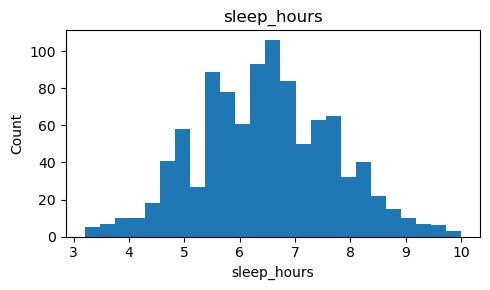

<Figure size 640x480 with 0 Axes>

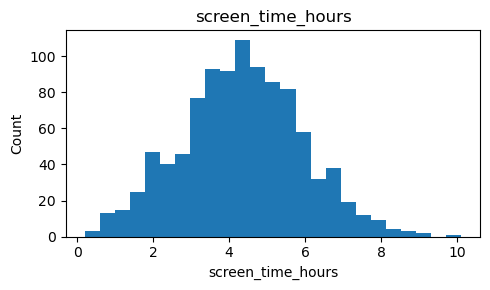

<Figure size 640x480 with 0 Axes>

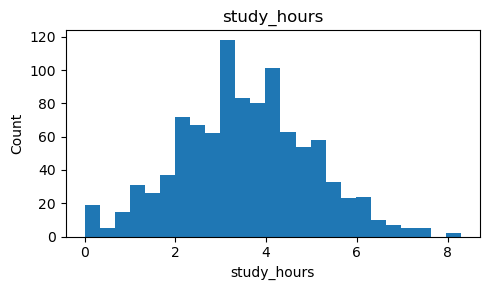

<Figure size 640x480 with 0 Axes>

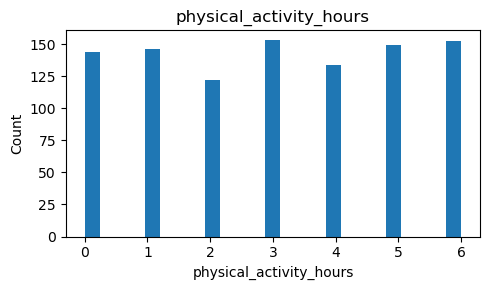

<Figure size 640x480 with 0 Axes>

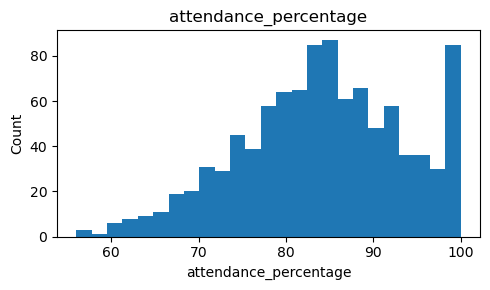

<Figure size 640x480 with 0 Axes>

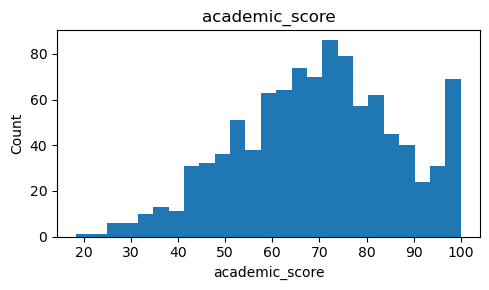

<Figure size 640x480 with 0 Axes>

In [9]:
for c in cols:
    plt.figure(figsize=(5,3))
    plt.hist(df[c].dropna(), bins=25)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    
    
    plt.show()
    
  
    plt.savefig(f'output/hist_{c}.png')

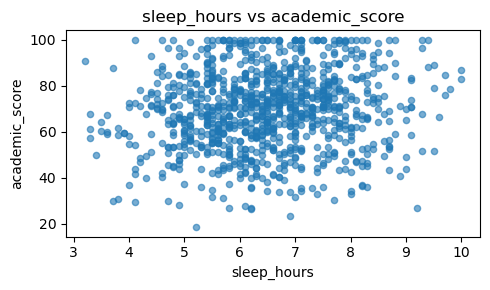

<Figure size 640x480 with 0 Axes>

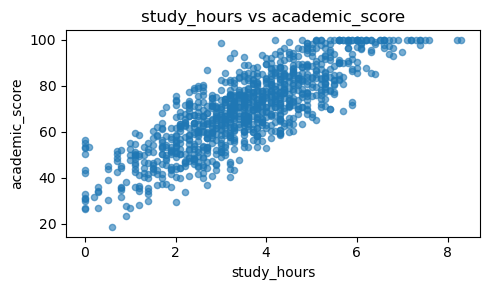

<Figure size 640x480 with 0 Axes>

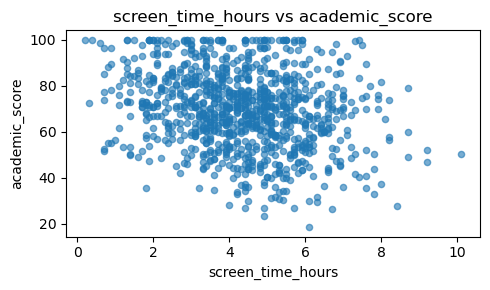

<Figure size 640x480 with 0 Axes>

In [10]:
for c in ['sleep_hours','study_hours','screen_time_hours']:
    if c in df.columns:
        plt.figure(figsize=(5,3))
        plt.scatter(df[c], df['academic_score'], alpha=0.6, s=20)
        plt.xlabel(c)
        plt.ylabel('academic_score')
        plt.title(f"{c} vs academic_score")
        plt.tight_layout()
        
        plt.show()
        
        plt.savefig(f'output/scatter_{c}_vs_score.png')

In [11]:
features = [c for c in ['sleep_hours','screen_time_hours','study_hours','physical_activity_hours','attendance_percentage'] if c in df.columns]
X = df[features]
y = df['academic_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [12]:
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"\nLinear Regression test MSE: {mse:.3f} | R²: {r2:.3f}")


Linear Regression test MSE: 57.778 | R²: 0.775


In [13]:
coef_df = pd.DataFrame({'feature': features, 'coefficient': model.coef_})
coef_df.to_csv('output/simple_model_coefficients.csv', index=False)
print("\nModel coefficients:")
print(coef_df)


Model coefficients:
                   feature  coefficient
0              sleep_hours     2.140578
1        screen_time_hours    -2.493001
2              study_hours     9.558831
3  physical_activity_hours     1.243857
4    attendance_percentage     0.155246


In [14]:
insights = []
for k,(r,p) in corrs.items():
    sig = "significant" if p < 0.05 else "not significant"
    insights.append(f"{k}: r={r:.3f}, p={p:.3e} ({sig})")
with open('output/simple_insights.txt','w') as f:
    for s in insights:
        f.write(s+"\n")
print("\nSaved simple_insights.txt and plots/coefficients in output/ folder.")


Saved simple_insights.txt and plots/coefficients in output/ folder.
